In [92]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from datetime import datetime


from nltk.corpus import gutenberg, stopwords
from collections import Counter

In [93]:
# Utility function for standard text cleaning.
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text
    
# Load and clean the data.
persuasion = gutenberg.raw('austen-persuasion.txt')
alice = gutenberg.raw('carroll-alice.txt')
emma = gutenberg.raw('austen-emma.txt')
whitman = gutenberg.raw('whitman-leaves.txt')

# The Chapter indicator is idiosyncratic
persuasion = re.sub(r'Chapter \d+', '', persuasion)
alice = re.sub(r'CHAPTER .*', '', alice)
emma = re.sub(r'VOLUME \w+', '', emma)
emma = re.sub(r'CHAPTER \w+', '', emma)
whitman = re.sub(r'VOLUME \w+', '', whitman)
whitman = re.sub(r'CHAPTER \w+', '', whitman)
    
alice = text_cleaner(alice)
persuasion = text_cleaner(persuasion)
emma = text_cleaner(emma)
whitman = text_cleaner(whitman)

In [94]:
start = datetime.now()
# Parse the cleaned novels. This can take a bit.
nlp = spacy.load('en')
alice_doc = nlp(alice)
print('Alice Parsed', datetime.now() - start)
persuasion_doc = nlp(persuasion)
print('Persuasion Parsed', datetime.now() - start)
emma_doc = nlp(emma)
print('Emma Parsed', datetime.now() - start)
whitman_doc = nlp(whitman)
print('Whitman Parsed', datetime.now() - start)
print('\nIt took the following time to complete this task:', datetime.now() - start)

Alice Parsed 0:00:13.896927
Persuasion Parsed 0:00:38.817070
Emma Parsed 0:01:34.714986
Whitman Parsed 0:02:09.210663

It took the following time to complete this task: 0:02:09.211653


In [95]:
# Group into sentences.
alice_sents = [[sent, "Carroll"] for sent in alice_doc.sents]
persuasion_sents = [[sent, "Austen"] for sent in persuasion_doc.sents]
emma_sents = [[sent, "Austen"] for sent in emma_doc.sents]
emma_sents = emma_sents[0:len(alice_sents)]
whitman_sents = [[sent, "Whitman"] for sent in whitman_doc.sents]
whitman_sents = whitman_sents[0:len(alice_sents)]

# Combine the sentences from the two novels into one data frame.
sentences1 = pd.DataFrame(alice_sents + persuasion_sents)
sentences1.head()

,0,1
0,"(Alice, was, beginning, to, get, very, tired, ...",Carroll
1,"(So, she, was, considering, in, her, own, mind...",Carroll
2,"(There, was, nothing, so, VERY, remarkable, in...",Carroll
3,"(Oh, dear, !)",Carroll
4,"(I, shall, be, late, !, ')",Carroll


In [96]:
# Utility function to create a list of the 3000 most common words.
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(3000)]
    

# Creates a data frame with features for each word in our common word set.
# Each value is the count of the times the word appears in each sentence.
def bow_features(sentences, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['text_sentence']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        
        POS = [token.pos_
              for token in sentence
              if (
                  not token.is_punct
                  and not token.is_stop
                  and token.pos_ in common_words
              )]
        
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
            
        for pos in POS:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 500 == 0:
            print("Processing row {}".format(i))
            
    return df

# Set up the bags.
alicewords = bag_of_words(alice_doc)
persuasionwords = bag_of_words(persuasion_doc)
emmawords = bag_of_words(emma_doc)
whitmanwords = bag_of_words(whitman_doc)

# Combine bags to create a set of unique words.
common_words1 = set(alicewords + persuasionwords)

In [97]:
# Create our data frame with features. This can take a while to run.
word_counts = bow_features(sentences1, common_words1)
word_counts.head()

Processing row 0
Processing row 500
Processing row 1000
Processing row 1500
Processing row 2000
Processing row 2500
Processing row 3000
Processing row 3500
Processing row 4000
Processing row 4500
Processing row 5000


,publicity,she,sugar,acceptable,poison,pitied,hit,umbrella,service,currant,...,after,closer,symptom,foolish,heighten,procure,those,talk,text_sentence,text_source
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Alice, was, beginning, to, get, very, tired, ...",Carroll
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(So, she, was, considering, in, her, own, mind...",Carroll
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(There, was, nothing, so, VERY, remarkable, in...",Carroll
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Oh, dear, !)",Carroll
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(I, shall, be, late, !, ')",Carroll


In [98]:

Y = word_counts['text_source']
X = np.array(word_counts.drop(['text_sentence','text_source'], 1))

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.4,
                                                    random_state=0)


In [99]:
#Create a testing function that will fit the test the data.
def testing_func(test, models):
    # This is a local list used to temporarily store scores
    scores=[]
    # This list serves the For loop below putting the variables in  
    train = test.fit(models[0], models[1])

    print('Training set score:', test.score(models[0], models[1]))
    print('\nTest set score:', test.score(models[2], models[3]))
    print('\nCV score:', np.mean(cross_val_score(test, models[0], models[1], cv=5)))                                           
 

# Challenge 0
Improve performance on test above 93% or on CV above 90%.

In [100]:
models = [X_train, y_train, X_test, y_test]

In [101]:
start = datetime.now()
rfc = ensemble.RandomForestClassifier(n_estimators=2000, n_jobs=4)
testing_func(rfc, models)
print('\nIt took the following time to complete this task:', datetime.now() - start)

Training set score: 0.9940438871473354

Test set score: 0.9050751879699248

CV score: 0.9025041950040216

It took the following time to complete this task: 0:08:49.350229


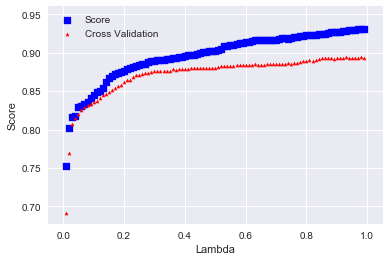

It took the following time to complete this task: 0:06:50.654666


In [102]:
start = datetime.now()
# Try to figure out the best Lambda for Lasso by running the test with the PCA X variable and mapping them out.
# Temporary lists to store the results
yl = []
cl = []

# For loop to run the model with different Lambdas represented as L
numb = np.arange(0.01, 1, 0.01)
for l in numb:
    lr = LogisticRegression(C=l, penalty='l1')
    train = lr.fit(X_train, y_train)
    yl.append(lr.score(X_train, y_train))
    cl.append(np.mean(cross_val_score(lr, X_train, y_train, cv=5)))

lambda_number = cl.index(max(cl)) + 1
# Plot the results of the accuracy and Cross Validation Score
fig = plt.figure()
ax1 = fig.add_subplot(111)
plt.xlabel('Lambda')
plt.ylabel('Score')
ax1.scatter(x=numb, y=yl, c='b', marker="s", label='Score')
ax1.scatter(x=numb, y=cl, s=10, c='r', marker="^", label='Cross Validation')
plt.legend(loc='upper left');
plt.show()
print('It took the following time to complete this task:', datetime.now() - start)

In [103]:
start = datetime.now()
lr = LogisticRegression(C=lambda_number)
testing_func(lr, models)
print('\nIt took the following time to complete this task:', datetime.now() - start)

Training set score: 0.9893416927899686

Test set score: 0.8947368421052632

CV score: 0.8877770132609515

It took the following time to complete this task: 0:00:04.586371


In [104]:
# SKlearn has a tool that will optimize SVC
start = datetime.now()
svc = SVC()

# Set the hyperparameters
svcparameters = {'C':[5,7,9], 'gamma': 
              [0.02,0.04,0.05]}

# Run it through the tool.
grid = GridSearchCV(svc, svcparameters).fit(X_train, y_train)
predicted = grid.predict(X_test)
print("The best parameters are {} with a score of %{}".format(grid.best_params_, grid.best_score_))

#Put those parameters in a dictionary to call.
svcparameters = grid.best_params_

print('It took the following time to complete this task:', datetime.now() - start)

The best parameters are {'C': 5, 'gamma': 0.05} with a score of %0.8987460815047021
It took the following time to complete this task: 0:16:14.405171


In [105]:
start = datetime.now()
svc = SVC(C=svcparameters['C'], gamma=svcparameters['gamma'])
testing_func(svc, models)
print('\nIt took the following time to complete this task:', datetime.now() - start)

Training set score: 0.9689655172413794

Test set score: 0.9135338345864662

CV score: 0.9037659735363197

It took the following time to complete this task: 0:03:37.239193


In [106]:
# Run the same optimization tool for gradient boosting
start = datetime.now()
clf = ensemble.GradientBoostingClassifier()
parameters = {'n_estimators':[100, 200], 'learning_rate': [ 0.5, 1.0]}
grid = GridSearchCV(clf, parameters).fit(X_train, y_train)
predicted = grid.predict(X_test)
print("The best parameters are {} with a score of %{}".format(grid.best_params_, grid.best_score_))

#Put those parameters in a dictionary to call.
parameters = grid.best_params_
print('It took the following time to complete this task:', datetime.now() - start)

The best parameters are {'learning_rate': 0.5, 'n_estimators': 200} with a score of %0.8818181818181818
It took the following time to complete this task: 0:11:56.293995


In [107]:
start = datetime.now()
clf = ensemble.GradientBoostingClassifier(n_estimators=parameters['n_estimators'], 
                                          learning_rate=parameters['learning_rate'])
testing_func(clf, models)
print('\nIt took the following time to complete this task:', datetime.now() - start)

Training set score: 0.977742946708464

Test set score: 0.8980263157894737

CV score: 0.8858980947512134

It took the following time to complete this task: 0:10:28.739975


In [108]:
start = datetime.now()
emma_sentences = pd.DataFrame(emma_sents)
emma_bow = bow_features(emma_sentences, common_words1)

print('\nIt took the following time to complete this task:', datetime.now() - start)

Processing row 0
Processing row 500
Processing row 1000
Processing row 1500

It took the following time to complete this task: 0:00:04.787884


In [109]:
start = datetime.now()
# Now we can model it!
# Let's use logistic regression again.

# Combine the Emma sentence data with the Alice data from the test set.
X_Emma_test = np.concatenate((
    X_train[y_train[y_train=='Carroll'].index],
    emma_bow.drop(['text_sentence','text_source'], 1)
), axis=0)
y_Emma_test = pd.concat([y_train[y_train=='Carroll'],
                         pd.Series(['Austen'] * emma_bow.shape[0])])

# Model.
print('\nTest set score:', lr.score(X_Emma_test, y_Emma_test))
lr_Emma_predicted = lr.predict(X_Emma_test)
pd.crosstab(y_Emma_test, lr_Emma_predicted)
print('\nIt took the following time to complete this task:', datetime.now() - start)


Test set score: 0.6580909768829232

It took the following time to complete this task: 0:00:01.487441


# Challenge 1
Find out whether your new model is good at identifying Alice in Wonderland vs any other work, Persuasion vs any other work, or Austen vs any other work. This will involve pulling a new book from the Project Gutenberg corpus (print(gutenberg.fileids()) for a list) and processing it.

In [110]:
start = datetime.now()
whitman_sentences = pd.DataFrame(whitman_sents)
whitman_bow = bow_features(whitman_sentences, common_words1)
print('\nIt took the following time to complete this task:', datetime.now() - start)

Processing row 0
Processing row 500
Processing row 1000
Processing row 1500

It took the following time to complete this task: 0:00:05.399147


## Alice vs. Whitman

In [111]:
New_Alice_Whitman = word_counts.drop(word_counts.text_source=='Austen', axis=0)
New_Alice_Whitman = pd.concat([New_Alice_Whitman, whitman_bow], axis=0)
y_Alice = New_Alice_Whitman['text_source']
X_Alice = np.array(New_Alice_Whitman.drop(['text_sentence','text_source'], 1))

X_Alice_train, X_Alice_test, y_Alice_train, y_Alice_test = train_test_split(X_Alice, 
                                                    y_Alice,
                                                    test_size=0.4,
                                                    random_state=0)


In [112]:
start = datetime.now()
# Now we can model it!
# Let's use svc again.
# Model.
print('\nTest set score:', svc.score(X_Alice_test, y_Alice_test))

print('\nIt took the following time to complete this task:', datetime.now() - start)


Test set score: 0.7208303507516106

It took the following time to complete this task: 0:00:26.657758


## Persuasion vs. Whitman

In [113]:
New_Persuasion_Whitman = word_counts.drop(word_counts.text_source=='Austen', axis=0)
New_Persuasion_Whitman = pd.concat([New_Persuasion_Whitman, whitman_bow], axis=0)
y_Persuasion = New_Persuasion_Whitman['text_source']
X_Persuasion = np.array(New_Persuasion_Whitman.drop(['text_sentence','text_source'], 1))

X_Persuasion_train, X_Persuasion_test, y_Persuasion_train, y_Persuasion_test = train_test_split(X_Persuasion, 
                                                    y_Persuasion,
                                                    test_size=0.4,
                                                    random_state=0)


In [114]:
start = datetime.now()
# Now we can model it!

# Model.
print('\nTest set score:', svc.score(X_Persuasion_test, y_Persuasion_test))

print('\nIt took the following time to complete this task:', datetime.now() - start)


Test set score: 0.7208303507516106

It took the following time to complete this task: 0:00:25.823148


## Austen vs. Whitman

In [115]:
sentences2 = pd.DataFrame(emma_sents + persuasion_sents + whitman_sents)
New_Austen_Whitman = bow_features(sentences2, common_words1)
y_Austen = New_Austen_Whitman['text_source']
X_Austen = np.array(New_Austen_Whitman.drop(['text_sentence','text_source'], 1))

X_Austen_train, X_Austen_test, y_Austen_train, y_Austen_test = train_test_split(X_Austen, 
                                                    y_Austen,
                                                    test_size=0.4,
                                                    random_state=0)
print(New_Austen_Whitman['text_source'].value_counts())

Processing row 0
Processing row 500
Processing row 1000
Processing row 1500
Processing row 2000
Processing row 2500
Processing row 3000
Processing row 3500
Processing row 4000
Processing row 4500
Processing row 5000
Processing row 5500
Processing row 6000
Processing row 6500
Austen     5318
Whitman    1669
Name: text_source, dtype: int64


In [116]:
start = datetime.now()

# Model.
print('\nTest set score:', svc.score(X_Austen_test, y_Austen_test))

print('\nIt took the following time to complete this task:', datetime.now() - start)


Test set score: 0.7373881932021467

It took the following time to complete this task: 0:00:21.577526
